In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import sounddevice as sd
import plotly.express as px
from rich import print
import math
from plotly.subplots import make_subplots

In [118]:
def fft_and_waveform(samples, fs=40_000.0):
    N = len(samples)
    # if N != 1024:
    #     raise ValueError("Expected 1024 samples")

    # Convert to numpy array
    x = np.asarray(samples, dtype=np.float64)

    # Time axis
    t = np.arange(N) / fs

    # Windowed FFT
    w = np.hanning(N)
    xw = (x - x.mean()) * w
    X = np.fft.rfft(xw, n=N)
    freqs = np.fft.rfftfreq(N, d=1/fs)

    cg = w.mean()
    mag = np.abs(X) / (N * cg)

    # Two subplots: waveform (top), FFT (bottom)
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=("Waveform", "FFT Spectrum"),
        vertical_spacing=0.15
    )

    # Time-domain waveform
    fig.add_trace(go.Scatter(
        x=t, y=x, mode="lines", name="Waveform"
    ), row=1, col=1)

    # Frequency-domain spectrum
    fig.add_trace(go.Scatter(
        x=freqs, y=mag, mode="lines", name="Magnitude Spectrum"
    ), row=2, col=1)

    fig.update_xaxes(title="Time (s)", row=1, col=1)
    fig.update_yaxes(title="Amplitude", row=1, col=1)

    fig.update_xaxes(title="Frequency (Hz)", row=2, col=1)
    fig.update_yaxes(title="Magnitude", row=2, col=1)

    fig.update_layout(height=600, template="plotly_white")

    return fig


In [101]:
def plot_spectrogram(samples, fs=10_000.0, n_fft=1024, hop=512, max_freq=None, min_freq=None):
    x = np.asarray(samples, dtype=np.float64)
    N = x.size

    # Hann window
    w = np.hanning(n_fft)

    # Number of frames
    n_frames = 1 + (N - n_fft) // hop
    n_bins = n_fft // 2 + 1

    # STFT
    S = np.empty((n_bins, n_frames), dtype=np.complex128)
    for i in range(n_frames):
        start = i * hop
        frame = x[start:start + n_fft]
        frame = (frame - frame.mean()) * w
        S[:, i] = np.fft.rfft(frame, n=n_fft)

    # Magnitude → dB
    mag = np.abs(S)
    mag /= (n_fft * (w.mean() if w.mean() != 0 else 1.0))
    S_db = 20.0 * np.log10(np.maximum(mag, 1e-12))

    # Axes
    times = (np.arange(n_frames) * hop) / fs
    freqs = np.fft.rfftfreq(n_fft, d=1.0/fs)

    # Apply frequency mask
    if max_freq is not None:
        mask = freqs <= max_freq
        freqs = freqs[mask]
        S_db = S_db[mask, :]

    if min_freq is not None:
        mask = freqs >= min_freq
        freqs = freqs[mask]
        S_db = S_db[mask, :]

    # Plot
    plt.figure(figsize=(9, 5))
    plt.imshow(
        S_db,
        origin='lower',
        aspect='auto',
        extent=[times[0], times[-1], freqs[0], freqs[-1]]
    )
    plt.colorbar(label='Magnitude (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Spectrogram up to {max_freq or fs/2:g} Hz')
    plt.tight_layout()
    plt.show()
    return S_db


In [72]:
def play_array(samples, fs=40_000):
    # Convert to float32
    x = np.asarray(samples, dtype=np.float32)

    # If it's raw ADC (unsigned, centered at ~2048), shift and scale
    if x.min() >= 0:
        x = (x - np.mean(x)) / np.max(np.abs(x))

    # Play
    sd.play(x, samplerate=fs)
    sd.wait()

In [ ]:
# Return True if n is a power of two and >= 2, else False
def is_pow2(n: int) -> bool:
    return (n >= 2) and ((n & (n - 1)) == 0)

# In-place bit-reversal permutation on re/im lists
def bit_reverse(re: list, im: list, n: int) -> None:
    j = 0
    for i in range(1, n - 1):
        bit = n >> 1
        while j & bit:
            j ^= bit
            bit >>= 1
        j ^= bit
        if i < j:
            re[i], re[j] = re[j], re[i]
            im[i], im[j] = im[j], im[i]

# In-place complex FFT (inverse = 0 forward, 1 inverse). Returns 0 on success, -1 on bad n.
def fft_simple(re: list, im: list, n: int, inverse: int) -> int:
    if not is_pow2(n):
        return -1

    # Put data in bit-reversed order
    bit_reverse(re, im, n)

    # Cooley–Tukey stages
    len_ = 2
    while len_ <= n:
        ang = (+1.0 if inverse else -1.0) * (2.0 * math.pi / float(len_))
        i = 0
        half = len_ >> 1
        while i < n:
            j = 0
            while j < half:
                theta = ang * float(j)
                w_re = math.cos(theta)
                w_im = math.sin(theta)

                p = i + j
                q = p + half

                ur = re[p]
                ui = im[p]
                tr = re[q] * w_re - im[q] * w_im
                ti = re[q] * w_im + im[q] * w_re

                re[p] = ur + tr
                im[p] = ui + ti
                re[q] = ur - tr
                im[q] = ui - ti

                j += 1
            i += len_
        len_ <<= 1

    # Normalize for inverse transform
    if inverse:
        invn = 1.0 / float(n)
        for k in range(n):
            re[k] *= invn
            im[k] *= invn

    return 0

# Convenience wrapper for real input: copies x -> re, zeros im, then forward FFT
def fft_real_simple(x: list) -> tuple[list, list]:
    n = len(x)
    if not is_pow2(n):
        raise ValueError("Length must be a power of two (>= 2)")
    re = [float(v) for v in x]
    im = [0.0] * n
    err = fft_simple(re, im, n, inverse=0)
    if err != 0:
        raise ValueError("fft_simple failed")
    return re, im

# Optional: magnitude spectrum |X[k]|
def fft_mag(re: list, im: list) -> list:
    return [math.hypot(re[k], im[k]) for k in range(len(re))]



In [188]:
def one_hz_sliding(x, fs, f0, n_fft=1024, window='hann', scale_like_fft=True):
    """
    Slide a length-n_fft window by 1 sample over x and compute the magnitude at frequency f0.
    - x: list/array of samples
    - fs: sample rate (Hz)
    - f0: target frequency (Hz)  (use f0=1.0 if you literally mean 1 Hz)
    - n_fft: window size (e.g., 1024)
    - window: 'hann' or None
    - scale_like_fft: if True, scales similar to |FFT bin| (≈ 2/(N*CG))

    Returns:
      times: list of center times (seconds) for each window
      mags:  list of magnitudes (linear)
    """
    N = n_fft
    H = 1  # slide by one sample
    L = len(x)
    if L < N:
        raise ValueError("Signal shorter than window.")

    # Window + coherent gain
    if window == 'hann':
        w = [0.5 - 0.5 * math.cos(2.0 * math.pi * n / (N - 1)) for n in range(N)]
        cg = sum(w) / N  # ~0.5 for Hann
    else:
        w = [1.0] * N
        cg = 1.0

    # Goertzel coefficient
    w0 = 2.0 * math.pi * (f0 / fs)
    c = 2.0 * math.cos(w0)

    frames = L - N + 1
    mags = [0.0] * frames
    times = [ (i + N/2.0) / fs for i in range(frames) ]

    # Brute-force per window (simple, readable)
    for i in range(frames):
        s0 = 0.0
        s1 = 0.0
        # windowed segment
        for n in range(N):
            xn = x[i + n] * w[n]
            s2 = s1
            s1 = s0
            s0 = xn + c * s1 - s2

        # Goertzel single-bin magnitude
        mag2 = s0*s0 + s1*s1 - c*s0*s1
        mag = math.sqrt(mag2)

        if scale_like_fft:
            mag *= (2.0 / (N * cg))

        mags[i] = mag

    return times, mags


In [ ]:
# Make a 1024-sample 440 Hz sine at 40 kHz
fs = 256
N = 1024*1
x = [
    math.sin(2.0 * math.pi * 4   * (n + 2) / N ) + 
     math.sin(2.0 * math.pi * 3.0  * (n + 3) / N )
     + math.sin(2.0 * math.pi * (20 + 0)  * (n + 3) / N ) 
     for n in range(N)]

fs = N
f0 = 20          # set to 1.0 if you literally want 1 Hz
t, a = one_hz_sliding(x, fs, f0, n_fft=1024, window='hann')
px.line(a).show()

# Forward FFT (real input)
re, im = fft_real_simple(x)

# Magnitude spectrum
mag = fft_mag(re, im)

# re, im now hold X[k]; mag is the linear amplitude per bin
px.line(x).show()
px.line(mag[:len(mag)//2]).show()


In [ ]:
arr = pd.read_excel('sh.xlsx', sheet_name='Sheet2').iloc[:1024,0].tolist()
fig = fft_and_waveform(arr)
fig.show()

In [79]:
arr = pd.read_excel('sh.xlsx', sheet_name='Sheet2').iloc[:,0].to_numpy()

In [152]:
info = goertzel_sliding(arr, 40000, 200)
px.line(arr).show()

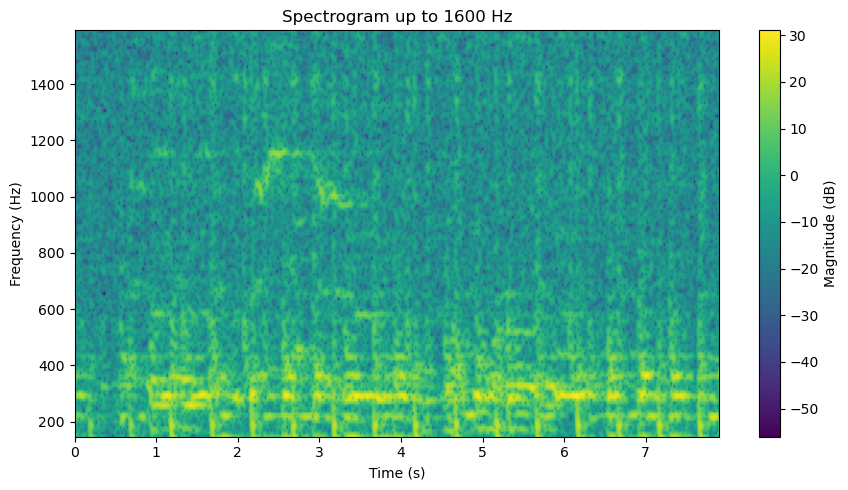

In [156]:
play_array(arr, 10000)
info = plot_spectrogram(arr, max_freq=1600, hop=128, min_freq=140)

In [10]:
16383, 0x3FFF

(16383, 16383)

In [ ]:
fft_and_waveform([i if i > -5 else i for i in info[0,:]], fs=618/4)

(2, 618)


In [31]:
np.pi/2

1.5707963267948966

In [ ]:
from pathlib import Path

Path("sine_table.h").write_text('const float SIN[65536] = {\n'
    + ',\n'.join([str(i+1) for i in np.sin(np.linspace(0, np.pi*2, 0x10000))])
    + '\n};\n')


1323568

In [158]:

Path("exp_table.h").write_text('const float EXP[1000] = {\n'
    + 'f,\n'.join([str(round(i, 8)) for i in np.exp(np.linspace(10, -10, 1000))])
    + '\n};\n')

13717

In [42]:
import numpy as np
import plotly.express as px
np.array([255, 0]) / 4080 + .2 - .03125
# (255/4080+.16)*4
.2-.03125
255*.000025 * 1000
255/(255/.1)+.05

'''66.00 1184.73 577.93 356.37 155.87'''

155.87/66
(1000 / 1023 - (1023/1023/2)) ** .5
1023/(1023/.3/2)
47.10
#OUT***************************************************
15.71
47.1-np.pi*2*5
46.47-np.pi*2*5, 15.71
np.power(2.5,3)*4*.01
1/.75/.75
16/6
length = (4+9/12)*2.54*12
width = 29
length, width
np.arcsin(width/length), np.arcsin(.5)
409/4096
(900-100)/2+100
.33, .33, .33
.33, .33, 0
.5, .5, 0
.5/.3333
.3333/.25
(1 - .5) * 1 / (3 - 1) + 1
'''
info->xamp1[j] = x_original[j] * amp_mult;
info->xamp1[j] = x_original[j] * ((1.0f - amp_mult) * (info->x_count - 1) + 1.0f);'''


(1/2 - 1/3 + 1) *1/3
1/3*3/2 * .1 * 3


0.15000000000000002

In [32]:
from pathlib import Path
h = 300

labels = {0:'info->rotate_angle_start', 1:'info->rotate_angle_step', 2:'info->xamp_start', 3:'info->xamp_step'}
ar = np.array([[float(j) for j in i.split()] for i in Path('t').read_text().replace('\n\n', '\n').splitlines()])
for i in range(ar.shape[1]):
    px.line(ar[:,i], width=1200, height=h, title=labels[i]).show()
    # ar2 = np.diff(ar[:,i])
    # px.line(ar2[(ar2>-39) & (ar2<39)], width=1200, height=h).show()
